# LMS Data Pipeline


In [4]:
# import libraries
import pandas as pd
import zipfile
import os

print("Pipeline Begins")
# zip Paths 
old_zip_path = "homework_old_lms_data.zip"
new_zip_path = "homework_new_lms_data.zip"

# extraction path
old_extract_path = "old_lms_data"
new_extract_path = "new_lms_data"

# Extract zip files
with zipfile.ZipFile(old_zip_path, 'r') as zip_ref:
    zip_ref.extractall(old_extract_path)
with zipfile.ZipFile(new_zip_path, 'r') as zip_ref:
    zip_ref.extractall(new_extract_path)

print("Loading old LMS")
# Load old LMS data
old_loans = pd.read_csv(f"{old_extract_path}/homework_old_lms_loans.csv")
old_customers = pd.read_csv(f"{old_extract_path}/homework_old_lms_customers.csv")
old_transactions = pd.read_csv(f"{old_extract_path}/homework_old_lms_transactions.csv")

# Load new LMS data
print("Loading New LMS")
new_loans = pd.read_csv(f"{new_extract_path}/homework_new_lms_loans.csv")
new_borrowers = pd.read_csv(f"{new_extract_path}/homework_new_lms_borrowers.csv")
loan_borrower = pd.read_csv(f"{new_extract_path}/homework_new_lms_loan_borrower.csv")
new_transactions = pd.read_csv(f"{new_extract_path}/homework_new_lms_transactions.csv")

# Process Old LMS
print("Processing old LMS")
#customers
old_customers['customer_id'] = old_customers['idCust']
old_customers['first_name'] = old_customers['txtFname']
old_customers['last_name'] = old_customers['txtLname']
old_customers['state'] = old_customers['txtState']
old_customers['source_system'] = 'old_lms'
#loans
old_loans['loan_id'] = old_loans['idLoan']
old_loans['customer_id'] = old_loans['idCust']
old_loans['loan_amount'] = old_loans['amtLoan']
old_loans['loan_date'] = old_loans['dtLoan']
old_loans['loan_status'] = old_loans['stsLoan']
old_loans['source_system'] = 'old_lms'
old_loans['last_updated'] = old_loans['updated_at']
#merge
old_merged = pd.merge(old_loans, old_customers, on='customer_id', how='left')
old_merged['source_system'] = old_merged['source_system_x']

# Process New LMS
print("Processing New LMS")
new_borrowers['customer_id'] = new_borrowers['borrower_tag'].str.replace("B-", "")
new_borrowers['source_system'] = 'new_lms'

new_loans['loan_id'] = new_loans['loan_tag'].str.replace("L-", "")
loan_borrower['loan_id'] = loan_borrower['loan_id']
loan_borrower['customer_id'] = loan_borrower['borrower_id']

new_loans_joined = pd.merge(loan_borrower, new_loans, on='loan_id', how='left')
new_merged = pd.merge(new_loans_joined, new_borrowers, left_on='customer_id', right_on='id', how='left')
new_merged['source_system'] = 'new_lms'
new_merged['last_updated'] = new_merged['lastUpdated']
new_merged['customer_id'] = new_merged['customer_id_y']
new_merged['loan_date'] = new_merged['contract_date']

#unified loan dataset
print("Generating Unified data")
columns_to_keep = ['loan_id', 'customer_id', 'loan_amount', 'loan_date', 'loan_status',
                   'source_system', 'first_name', 'last_name', 'state', 'last_updated']
old_final = old_merged[columns_to_keep]
new_final = new_merged[columns_to_keep]
unified_loans = pd.concat([old_final, new_final], ignore_index=True)

unified_loans.to_excel("unified_loan_dataset.xlsx", index=False)

#process transactions data
print("Processing transactionss")
old_transactions['loan_id'] = old_transactions['idLoan']
old_transactions['transaction_type'] = old_transactions['txtTranType'].str.upper()
old_transactions['principal_amount'] = old_transactions['amtPrin']
old_transactions['interest_amount'] = old_transactions['amtInt']
old_transactions['post_date'] = old_transactions['dtPost']
old_transactions['effective_date'] = old_transactions['dtEffect']
old_transactions['created_at'] = old_transactions['created_at']
old_transactions['updated_at'] = old_transactions['updated_at']
old_transactions['source_system'] = 'old_lms'

new_transactions['transaction_type'] = new_transactions['transaction_type'].str.upper()
new_transactions['source_system'] = 'new_lms'
new_transactions['created_at'] = new_transactions['created']
new_transactions['updated_at'] = new_transactions['lastUpdated']

print("Generating transactions data")
columns = ['loan_id', 'transaction_type', 'principal_amount', 'interest_amount',
           'post_date', 'effective_date', 'created_at', 'updated_at', 'source_system']

old_txn_final = old_transactions[columns]
new_txn_final = new_transactions[columns]
unified_transactions = pd.concat([old_txn_final, new_txn_final], ignore_index=True)
unified_transactions.to_excel("unified_transactions_dataset.xlsx", index=False)

print("Pipeline Ends")


Pipeline Begins
Loading old LMS
Loading New LMS
Processing old LMS
Processing New LMS
Generating Unified data
Processing transactionss
Generating transactions data
Pipeline Ends


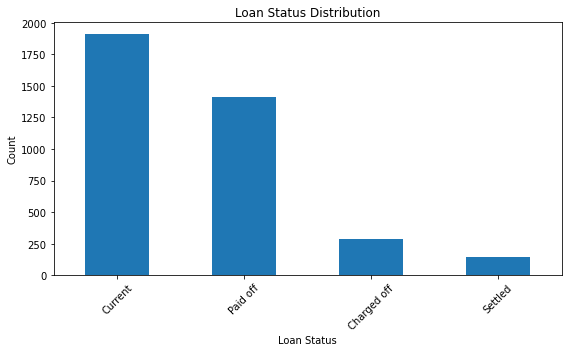

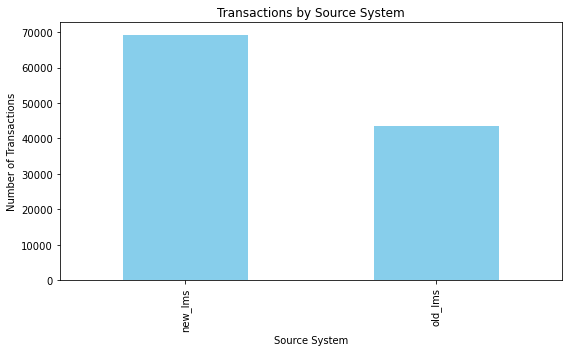

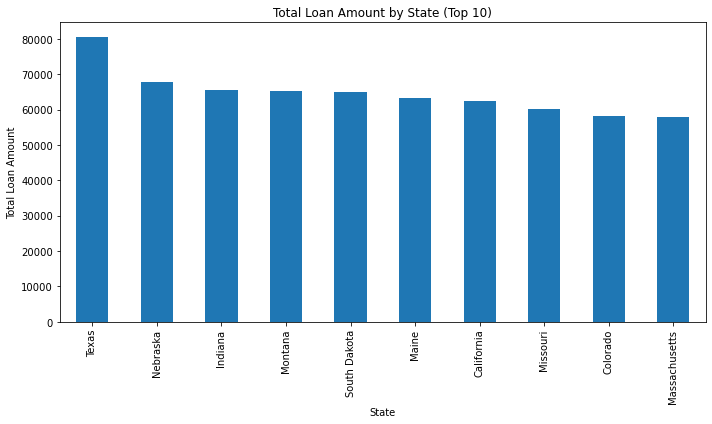

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

#load the datasets
unified_loans = pd.read_excel("unified_loan_dataset.xlsx")
unified_transactions = pd.read_excel("unified_transactions_dataset.xlsx")

#Loan Status Distribution plot
plt.figure(figsize=(8, 5))
unified_loans['loan_status'].value_counts().plot(kind='bar')
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("loan_status_distribution.png")
plt.show()

#Transactions by Source System plot
plt.figure(figsize=(8, 5))
unified_transactions['source_system'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Transactions by Source System')
plt.xlabel('Source System')
plt.ylabel('Number of Transactions')
plt.tight_layout()
plt.savefig("transactions_by_source_system.png")
plt.show()

#3. Total Loan Amount by State -Top 10
plt.figure(figsize=(10, 6))
unified_loans.groupby('state')['loan_amount'].sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Total Loan Amount by State (Top 10)')
plt.xlabel('State')
plt.ylabel('Total Loan Amount')
plt.tight_layout()
plt.savefig("loan_amount_by_state.png")
plt.show()
